In [1]:
import sys
from glob import glob

import time
import h5py
import zarr
#import numba as nb
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

from datetime import datetime, timedelta

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_80km = h5io['lon_80km'][...]
    lat_80km = h5io['lat_80km'][...]
    land_mask_80km = h5io['land_mask_80km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

**Old mean and std numbers**

In [4]:
means = [
    -6.335041783675384,
    101598.30648208999,
    2.4340308170812857,
    0.0238316214287872,
    0.0115228964831135,
    0.015723252607236175,
    0.00010298927478466365,
    0.00013315081911787703,
    0.02022990418418194,
    285.1588453352469,
    280.69456763975046,
    0.18025322895802864,
    -0.35625256772098957,
    4.466962100212334,
    0.10710428466431396,
    311.51020050786116,
    -22.95554152474839,
    95.80303950026172,
    41.22773039479408,
    2.696538199313979,
    0.257023643073863,
    11.80181492281666,
    0.15778718430103703,
];

stds = [
    8.872575669978966,
    672.3339463894478,
    7.555104640235371,
    0.5696550725786566,
    0.2283199203388272,
    0.37333362094670486,
    0.00022281640603195643,
    0.0002413561909874066,
    0.3589573748563584,
    11.553795616392204,
    12.101590155483459,
    3.1758721705443826,
    3.6588052023281175,
    2.6995797278745948,
    0.9896017905552607,
    748.8376068157106,
    78.895180023938,
    104.17948262883918*2,
    77.25788246299936*2,
    5.35086729614372,
    5.438075471238217,
    11.440203318938076,
    11.327741531273508
];


**Pick predictors from HRRR variables**

In [5]:
names = [
    "Log norm'd Max/Comp Radar",
    'MSLP',
    'AGL',
    "Log norm'd UH 2-5 km",
    "Log norm'd UH 0-2 km",
    "Log norm'd UH 0-3 km",
    'Vorticity 0-2 km',
    'Vorticity 0-1 km',
    "Log norm'd Graupel mass",
    'T 2m',
    'Dewpoint 2m',
    'U 10m',
    'V 10m',
    'SPD 10m',
    "Log norm'd APCP",
    "Log norm'd CAPE",
    "Log norm'd CIN",
    'SRH 0-3 km',
    'SRH 0-1 km',
    'U shear 0-1 km',
    'V shear 0-1 km',
    'U shear 0-6 km',
    'V shear 0-6 km']

ind_pick = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]

mean_pick = []
std_pick = []
name_pick = []

for i in ind_pick:
    mean_pick.append(means[i])
    std_pick.append(stds[i])
    name_pick.append(names[i])


In [6]:
name_pick

["Log norm'd Max/Comp Radar",
 'MSLP',
 "Log norm'd UH 2-5 km",
 "Log norm'd UH 0-2 km",
 "Log norm'd Graupel mass",
 'T 2m',
 'Dewpoint 2m',
 'SPD 10m',
 "Log norm'd APCP",
 "Log norm'd CAPE",
 "Log norm'd CIN",
 'SRH 0-3 km',
 'SRH 0-1 km',
 'U shear 0-6 km',
 'V shear 0-6 km']

In [7]:
shape_3km = land_mask_3km.shape
shape_80km = land_mask_80km.shape

In [12]:
stats234v3 = np.load('/glade/work/ksha/NCAR/stats_allv4_80km_full_lead{}{}{}.npy'.format(2, 3, 4))
stats345v3 = np.load('/glade/work/ksha/NCAR/stats_allv4_80km_full_lead{}{}{}.npy'.format(3, 4, 5))
stats456v3 = np.load('/glade/work/ksha/NCAR/stats_allv4_80km_full_lead{}{}{}.npy'.format(4, 5, 6))
stats567v3 = np.load('/glade/work/ksha/NCAR/stats_allv4_80km_full_lead{}{}{}.npy'.format(5, 6, 7))
# stats678v3 = np.load('/glade/work/ksha/NCAR/stats_allv3_80km_full_lead{}{}{}.npy'.format(6, 7, 8))
# stats789v3 = np.load('/glade/work/ksha/NCAR/stats_allv3_80km_full_lead{}{}{}.npy'.format(7, 8, 9))

In [13]:
stats234v4 = np.load('/glade/work/ksha/NCAR/stats_allv4x_80km_full_lead{}{}{}.npy'.format(2, 3, 4))
stats345v4 = np.load('/glade/work/ksha/NCAR/stats_allv4x_80km_full_lead{}{}{}.npy'.format(3, 4, 5))
stats456v4 = np.load('/glade/work/ksha/NCAR/stats_allv4x_80km_full_lead{}{}{}.npy'.format(4, 5, 6))
stats567v4 = np.load('/glade/work/ksha/NCAR/stats_allv4x_80km_full_lead{}{}{}.npy'.format(5, 6, 7))
# stats678v4 = np.load('/glade/work/ksha/NCAR/stats_allv4_80km_full_lead{}{}{}.npy'.format(6, 7, 8))
# stats789v4 = np.load('/glade/work/ksha/NCAR/stats_allv4_80km_full_lead{}{}{}.npy'.format(7, 8, 9))

In [14]:
np.nansum(stats567v4-stats567v3)

-4824.142222923341

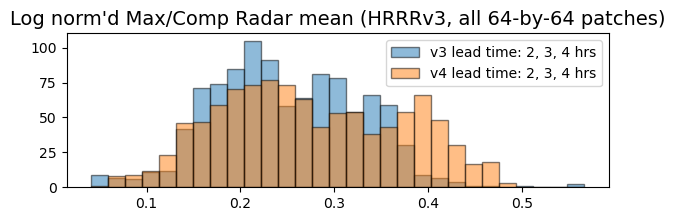

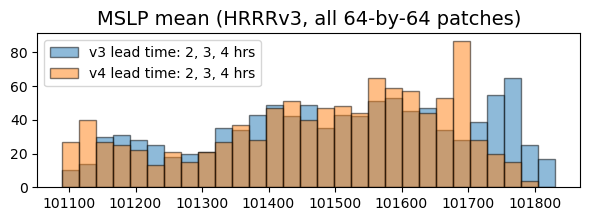

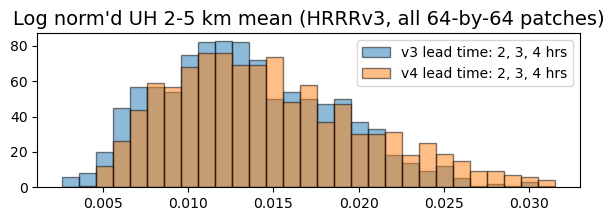

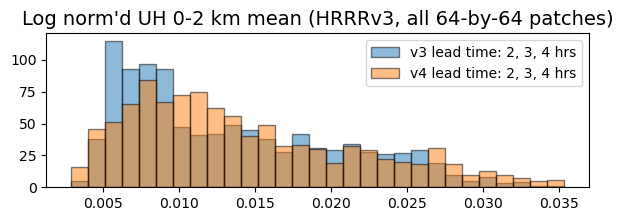

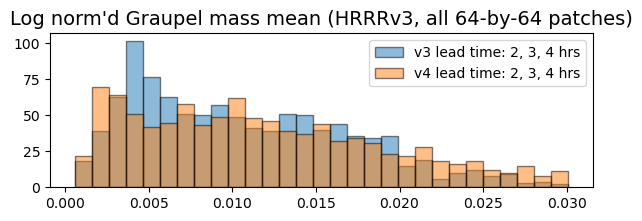

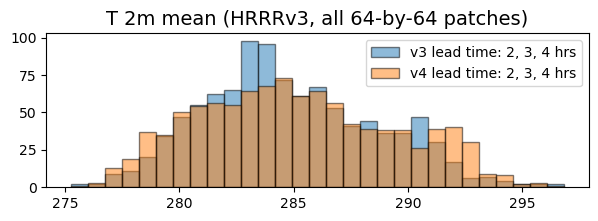

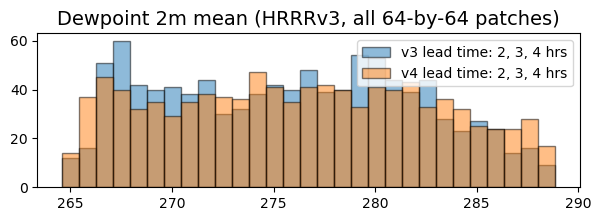

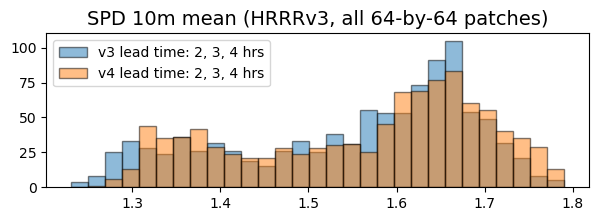

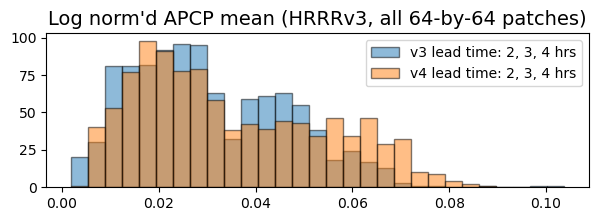

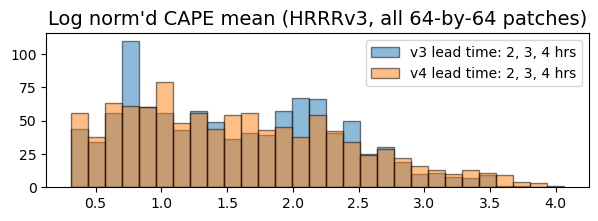

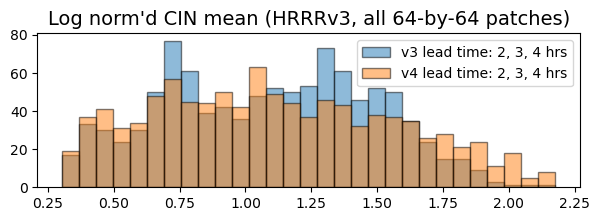

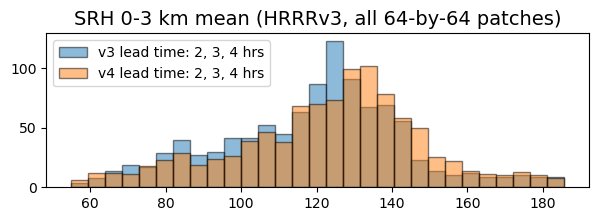

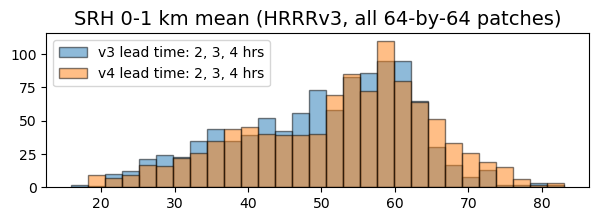

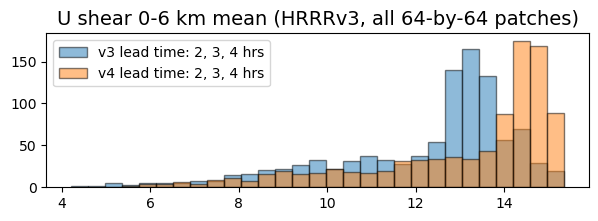

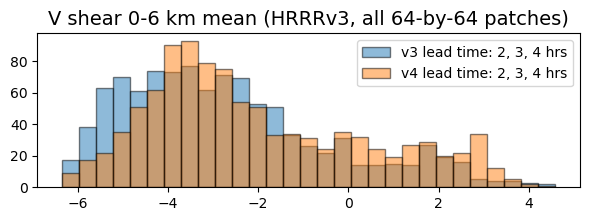

In [15]:
for ind_var in range(15):

    var234v3 = stats234v3[:, :, ind_var, 0]
    var234v4 = stats234v4[:, :, ind_var, 0]
    
    flag_nan = ~np.isnan(var234v3)
    bin_range = np.linspace(np.min(var234v3[flag_nan]), np.max(var234v3[flag_nan]), 30)
    
    fig = plt.figure(figsize=(7, 2))
    plt.hist(var234v3[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='v3 lead time: 2, 3, 4 hrs');
    plt.hist(var234v4[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='v4 lead time: 2, 3, 4 hrs');
    
    plt.title(name_pick[ind_var]+' mean (HRRRv3, all 64-by-64 patches)', fontsize=14)
    plt.legend()

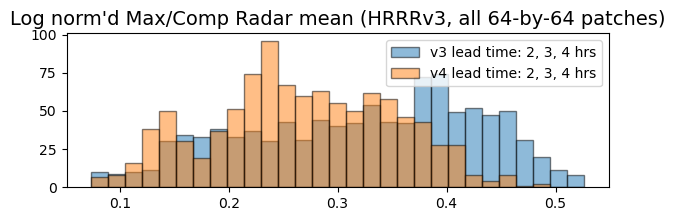

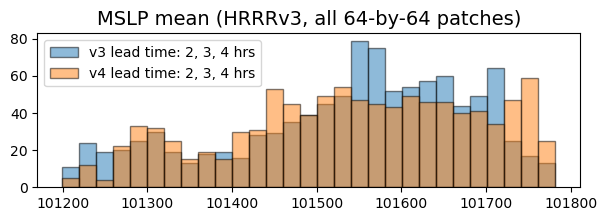

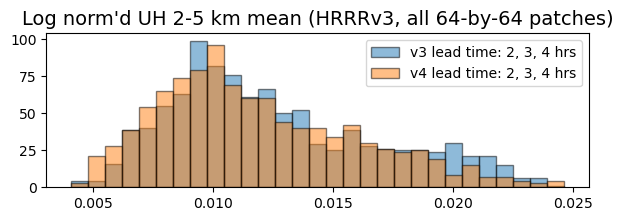

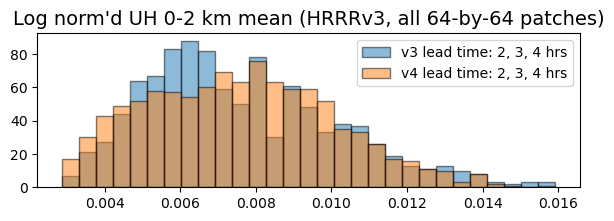

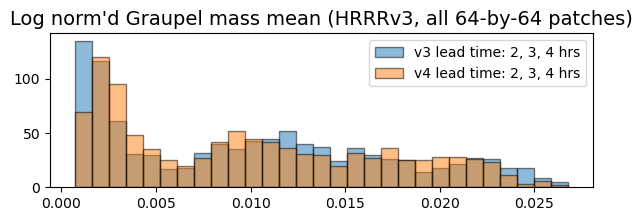

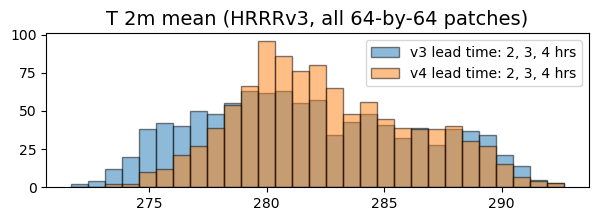

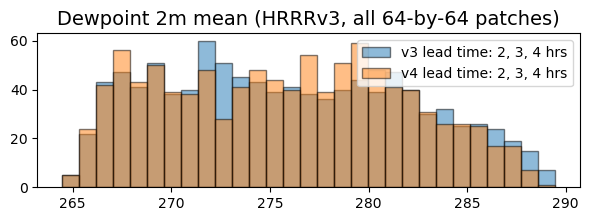

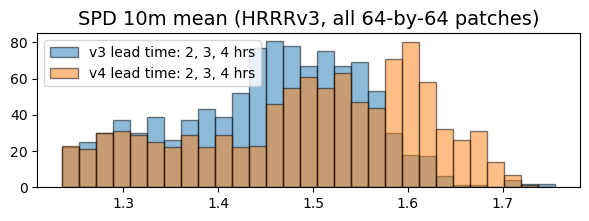

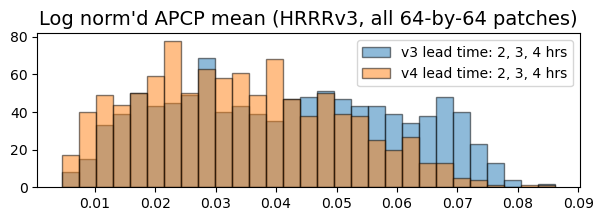

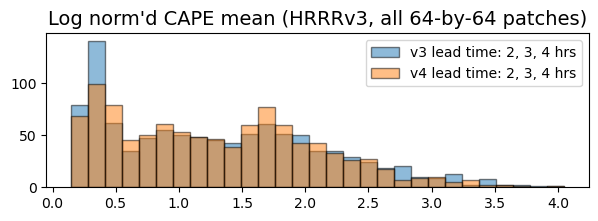

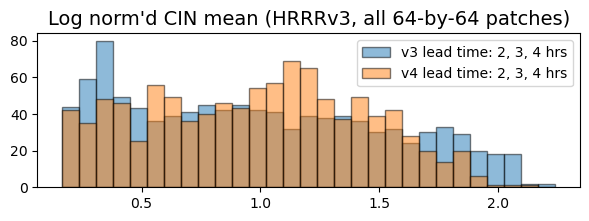

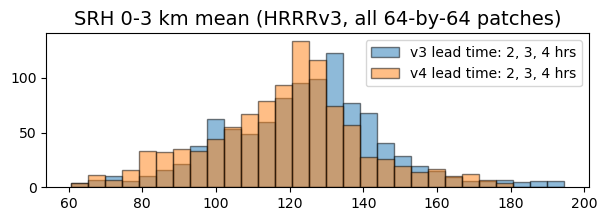

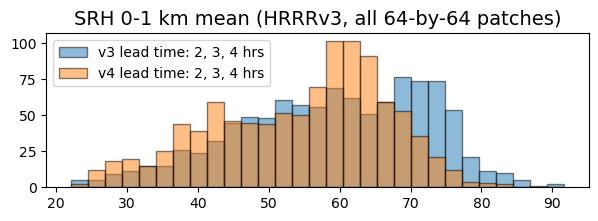

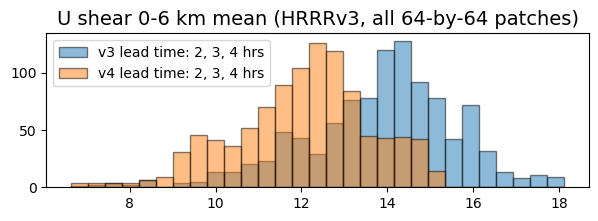

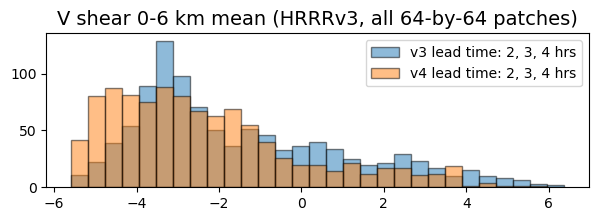

In [16]:
for ind_var in range(15):

    var234v3 = stats678v3[:, :, ind_var, 0]
    var234v4 = stats678v4[:, :, ind_var, 0]
    
    flag_nan = ~np.isnan(var234v3)
    bin_range = np.linspace(np.min(var234v3[flag_nan]), np.max(var234v3[flag_nan]), 30)
    
    fig = plt.figure(figsize=(7, 2))
    plt.hist(var234v3[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='v3 lead time: 2, 3, 4 hrs');
    plt.hist(var234v4[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='v4 lead time: 2, 3, 4 hrs');
    
    plt.title(name_pick[ind_var]+' mean (HRRRv3, all 64-by-64 patches)', fontsize=14)
    plt.legend()

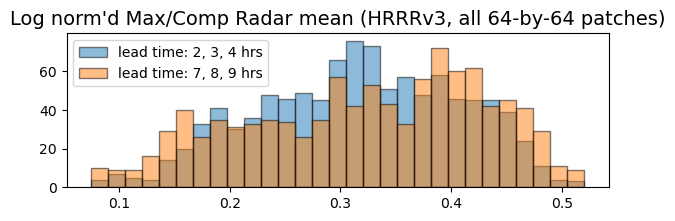

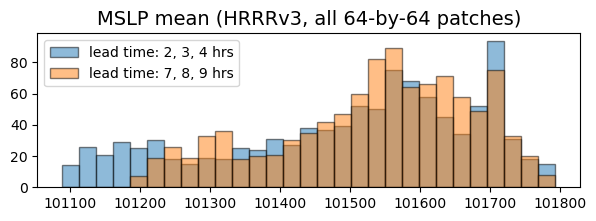

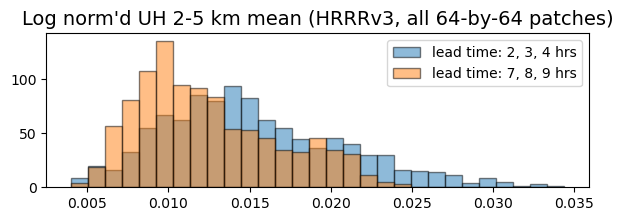

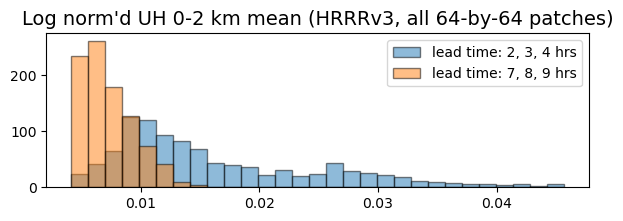

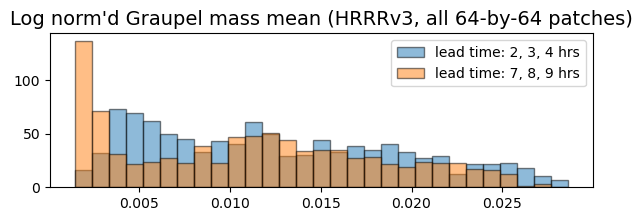

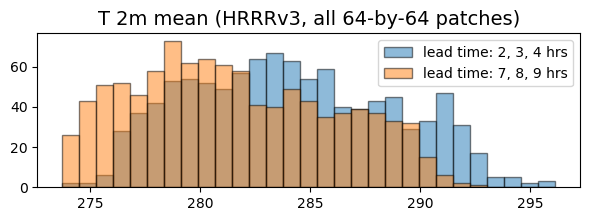

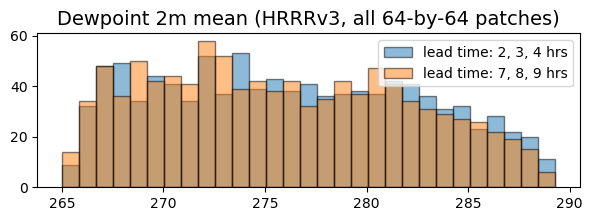

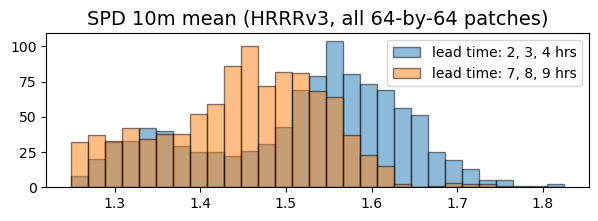

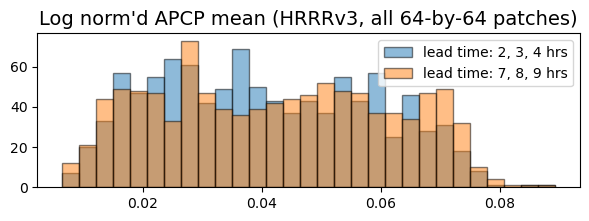

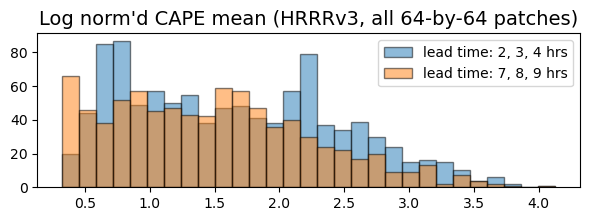

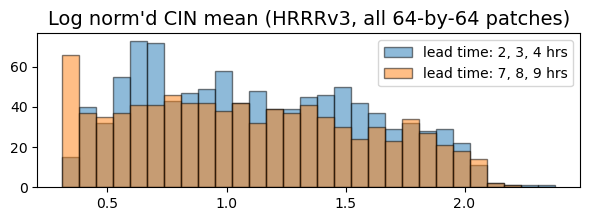

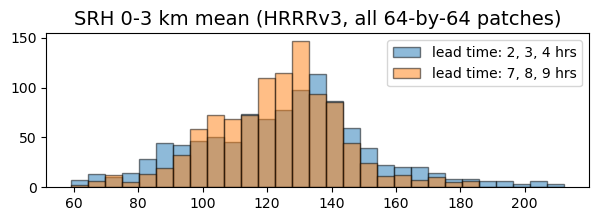

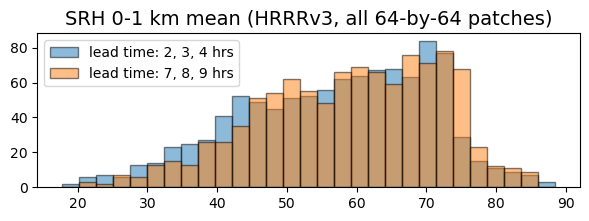

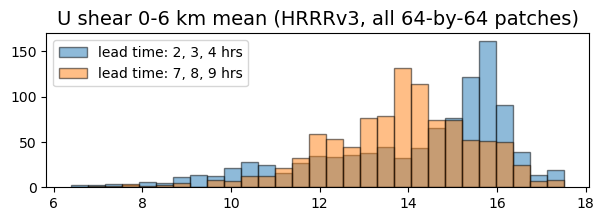

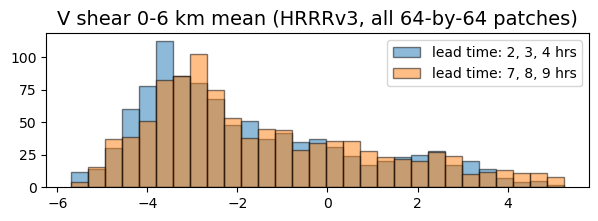

In [38]:
for ind_var in range(15):

    var234 = stats234[:, :, ind_var, 0]
    var345 = stats345[:, :, ind_var, 0]
    var456 = stats456[:, :, ind_var, 0]
    var567 = stats567[:, :, ind_var, 0]
    var678 = stats678[:, :, ind_var, 0]
    var789 = stats789[:, :, ind_var, 0]

    flag_nan = ~np.isnan(var234)
    bin_range = np.linspace(np.min(var234[flag_nan]), np.max(var234[flag_nan]), 30)
    
    fig = plt.figure(figsize=(7, 2))
    plt.hist(var234[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 2, 3, 4 hrs');
    #plt.hist(var345[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 3, 4, 5 hrs');
    #plt.hist(var567[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 5, 6, 7 hrs');
    #plt.hist(var678[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 6, 7, 8 hrs');
    plt.hist(var789[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 7, 8, 9 hrs');
    
    plt.title(name_pick[ind_var]+' mean (HRRRv3, all 64-by-64 patches)', fontsize=14)
    plt.legend()

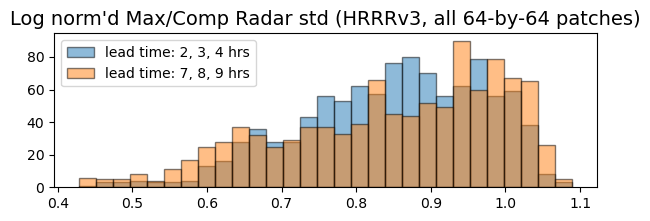

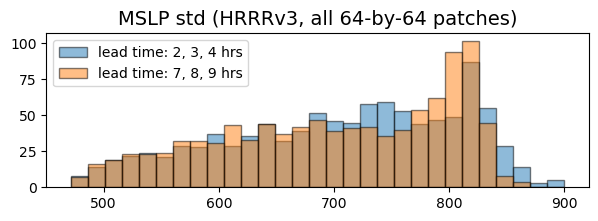

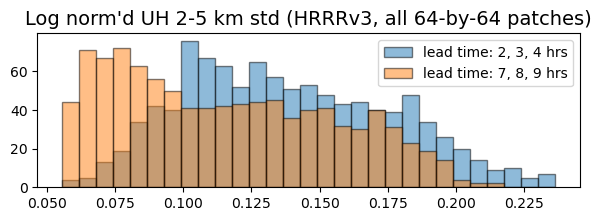

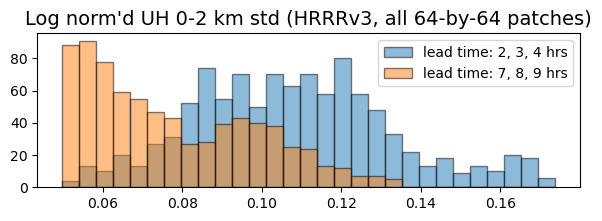

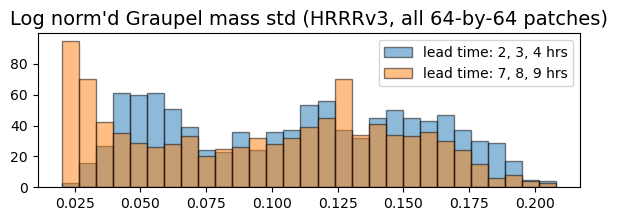

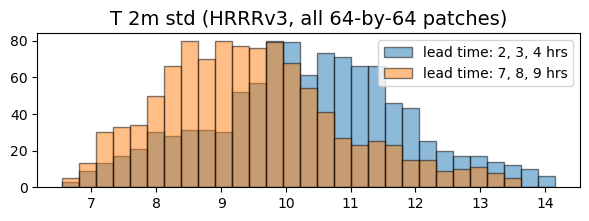

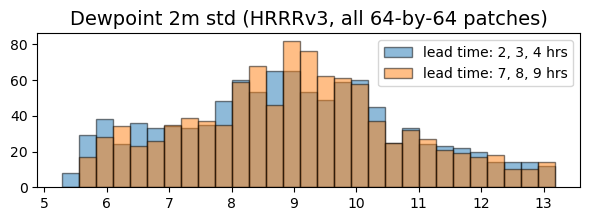

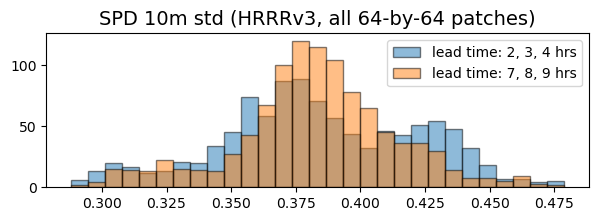

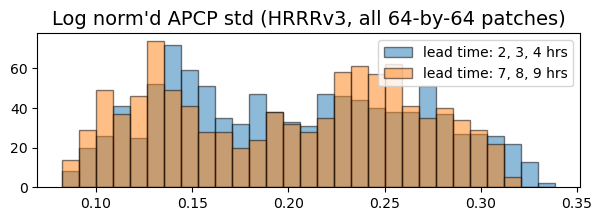

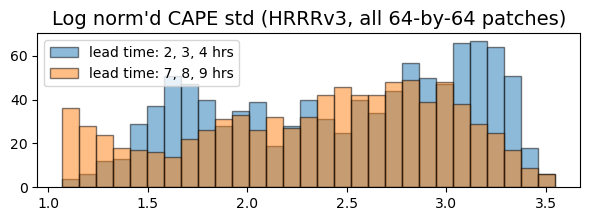

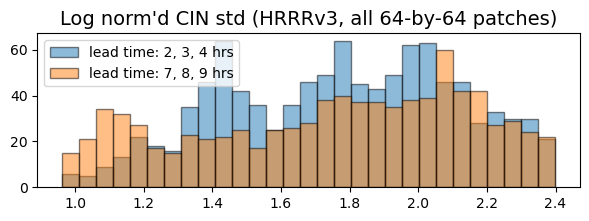

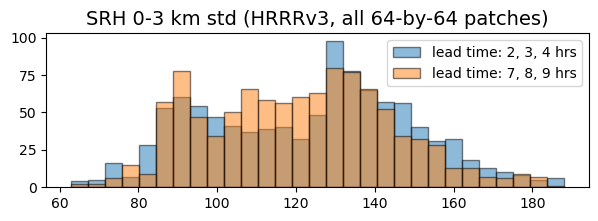

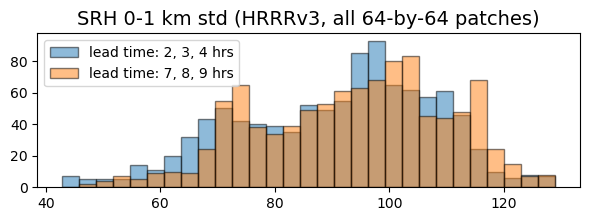

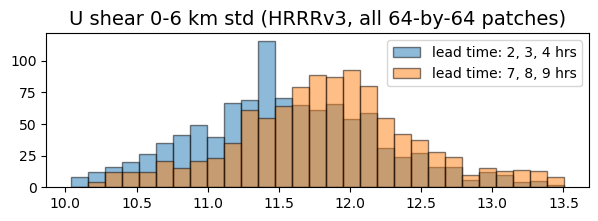

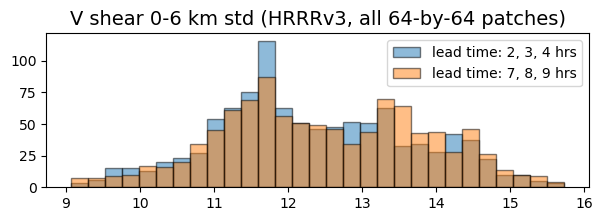

In [39]:
for ind_var in range(15):

    var234 = stats234[:, :, ind_var, 1]
    var345 = stats345[:, :, ind_var, 1]
    var456 = stats456[:, :, ind_var, 1]
    var567 = stats567[:, :, ind_var, 1]
    var678 = stats678[:, :, ind_var, 1]
    var789 = stats789[:, :, ind_var, 1]

    flag_nan = ~np.isnan(var234)
    bin_range = np.linspace(np.min(var234[flag_nan]), np.max(var234[flag_nan]), 30)
    
    fig = plt.figure(figsize=(7, 2))
    plt.hist(var234[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 2, 3, 4 hrs');
    #plt.hist(var345[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 3, 4, 5 hrs');
    #plt.hist(var567[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 5, 6, 7 hrs');
    #plt.hist(var678[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 6, 7, 8 hrs');
    plt.hist(var789[flag_nan], bins=bin_range, edgecolor='k', alpha=0.5, label='lead time: 7, 8, 9 hrs');
    
    plt.title(name_pick[ind_var]+' std (HRRRv3, all 64-by-64 patches)', fontsize=14)
    plt.legend()